In [22]:
import numpy as np
import time
import copy
from tqdm import tqdm
import os

import importlib, FeatSubLib, dataset_ffcv_torch
importlib.reload(FeatSubLib)
importlib.reload(dataset_ffcv_torch)
from FeatSubLib import FeatureNet, CustomCallback, CustomMultiReadoutCallback, CustomModel, CustomMultiReadoutModel, time_diff
import dataset_ffcv_torch as ds

import matplotlib as mpl
from matplotlib import pyplot as plt

from collections import OrderedDict

import torch
from torch.optim import SGD, Adam, lr_scheduler
device = 'cuda'

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta
tz = pytz.timezone('US/Eastern')

def time_now():
    return datetime.now(tz)

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [23]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
linestyles = ['--', ':', '-.']
markerstyles = ['.','*','x']

In [24]:
#Width and height of axes.
w=3
h=3
plt.rcParams.update({'font.size': 12, 'figure.figsize': [w,h]})

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['legend.title_fontsize'] = 'small'

#Helper Function for setting figure size by axis size.
#set_size(w,h,ax)
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [25]:
#Mnist, neural projections, gradient linear regression-trianed
#dataset = 'mnist'
dataset = 'cifar10'
projType = 'np'
readoutLearnRule = 'lr'
OutputStrategy = 'threshmean'

distType = 'gamma'

In [26]:
pathHead = dataset+'_' + projType + '_' + readoutLearnRule + '_'+distType+'Conn_'+OutputStrategy
desc = pathHead#description
dataPath = pathHead+'_data/'
figPath = pathHead+'_figs/'

if not os.path.exists(dataPath):
    raise Exception('Corresponding Data Path Does Not Exist!')

if not os.path.exists(figPath):
    # Create a new directory because it does not exist 
    os.makedirs(figPath)
    print("The new Figure directory is created!")

The new Figure directory is created!


In [27]:
# relaod data:
#proj_ratio_list = np.load(dataPath+'proj_ratio_list.npy')
num_samples_list = np.load(dataPath+'num_samples_list.npy')
shift_list = np.load(dataPath+'shift_list.npy')
KVals = np.load(dataPath+'K_list.npy')
sparsityFractions = np.load(dataPath+'sparsity_fracs.npy')
sparsityVariances = np.load(dataPath+'sparsity_vars.npy')

tr_loss=torch.load(dataPath+'tr_loss.pt')
test_loss=torch.load(dataPath+'test_loss.pt')
tr_acc=torch.load(dataPath+'tr_acc.pt')
test_acc=torch.load(dataPath+'test_acc.pt')
tr_err = torch.load(dataPath+'tr_err.pt')
test_err = torch.load(dataPath+'test_err.pt')

In [28]:
tr_acc.shape

(40, 4, 1, 20)

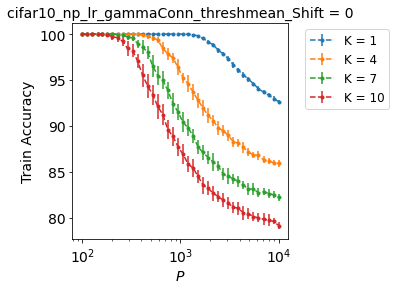

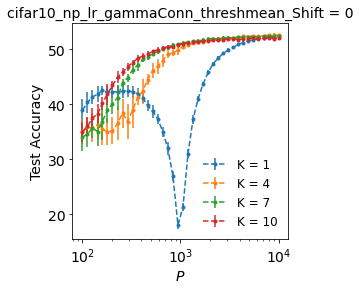

In [29]:
for shiftInd, shift in enumerate(shift_list):
    fig, ax = plt.subplots()
    for KInd, K in enumerate(KVals):
        #ax.plot(num_samples_list, tr_acc.mean(3)[:,KInd,shiftInd], color = colors[KInd%len(colors)], ls = linestyles[0], marker = markerstyles[0], label = 'K = ' + str(K))
        ax.errorbar(num_samples_list, tr_acc.mean(3)[:,KInd,shiftInd], tr_acc.std(3)[:,KInd,shiftInd], color = colors[KInd%len(colors)], ls = linestyles[0], marker = markerstyles[0], label = 'K = ' + str(K))
#     ylim = ax.get_ylim()[0]
#     for shiftInd, shift in enumerate(shift_list):
#         ax.plot(sparsityFractions[shiftInd], ylim, marker='v', color = colors[shiftInd])
    ax.set_xlabel(r'$P$')
    ax.set_ylabel(r'Train Accuracy')
    ax.set_xscale('log')
    
    #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
    ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    ax.set_title(desc + '_Shift = ' + str(shift))
    fig = plt.gcf()
    set_size(w,h)
    fig.savefig(figPath+'train_acc_plot_Shift'+str(shift)+'.png', dpi = 300, bbox_inches='tight')
    
for shiftInd, shift in enumerate(shift_list):
    fig, ax = plt.subplots()
    for KInd, K in enumerate(KVals):
        #ax.plot(num_samples_list, test_acc.mean(3)[:,KInd,shiftInd], color = colors[KInd%len(colors)], ls = linestyles[0], marker = markerstyles[0], label = 'K = ' + str(K)) 
        ax.errorbar(num_samples_list, test_acc.mean(3)[:,KInd,shiftInd], test_acc.std(3)[:,KInd,shiftInd], color = colors[KInd%len(colors)], ls = linestyles[0], marker = markerstyles[0], label = 'K = ' + str(K)) 
        
    ax.set_xlabel(r'$P$')
    ax.set_ylabel(r'Test Accuracy')
    ax.set_xscale('log')
    
    #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
    ax.legend(loc = 'lower right', frameon=False)
    ax.set_title(desc + '_Shift = ' + str(shift))
    set_size(w,h)
    fig = plt.gcf()
    fig.savefig(figPath+'test_acc_plot_Shift'+str(shift)+'.png', dpi = 300, bbox_inches='tight')

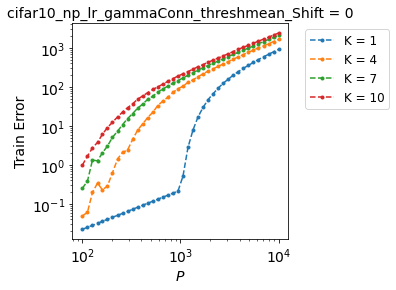

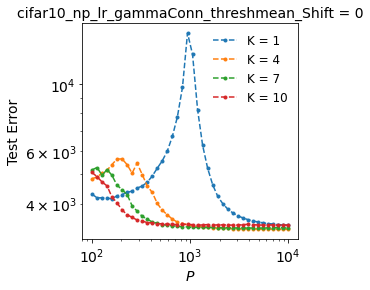

In [30]:
for shiftInd, shift in enumerate(shift_list):
    fig, ax = plt.subplots()
    for KInd, K in enumerate(KVals):
        ax.loglog(num_samples_list, tr_err.mean(3)[:,KInd,shiftInd], color = colors[KInd%len(colors)], ls = linestyles[0], marker = markerstyles[0], label = 'K = ' + str(K))        
        #ax.errorbar(proj_ratio_list, tr_acc.mean(3)[PInd,KInd,:,shiftInd], tr_acc.std(3)[PInd,KInd,:, shiftInd], label = shift, color = colors[shiftInd], ls = linestyles[KInd])        
#     ylim = ax.get_ylim()[0]
#     for shiftInd, shift in enumerate(shift_list):
#         ax.plot(sparsityFractions[shiftInd], ylim, marker='v', color = colors[shiftInd])
    ax.set_xlabel(r'$P$')
    ax.set_ylabel(r'Train Error')
    
    #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
    ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    ax.set_title(desc + '_Shift = ' + str(shift))
    set_size(w,h)
    fig = plt.gcf()
    fig.savefig(figPath+'train_err_plot_Shift'+str(shift)+'.png', dpi = 300, bbox_inches='tight')
    
for shiftInd, shift in enumerate(shift_list):
    fig, ax = plt.subplots()
    for KInd, K in enumerate(KVals):
        ax.loglog(num_samples_list, test_err.mean(3)[:,KInd,shiftInd], color = colors[KInd%len(colors)], ls = linestyles[0], marker = markerstyles[0], label = 'K = ' + str(K))        
        #ax.errorbar(proj_ratio_list, tr_acc.mean(3)[PInd,KInd,:,shiftInd], tr_acc.std(3)[PInd,KInd,:, shiftInd], label = shift, color = colors[shiftInd], ls = linestyles[KInd])        
#     ylim = ax.get_ylim()[0]
#     for shiftInd, shift in enumerate(shift_list):
#         ax.plot(sparsityFractions[shiftInd], ylim, marker='v', color = colors[shiftInd])
    ax.set_xlabel(r'$P$')
    ax.set_ylabel(r'Test Error')
    
    #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
    #ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    ax.legend(loc = 'upper right', frameon=False)
    ax.set_title(desc + '_Shift = ' + str(shift))
    set_size(w,h)
    fig = plt.gcf()
    fig.savefig(figPath+'test_err_plot_Shift'+str(shift)+'.png', dpi = 300, bbox_inches='tight')

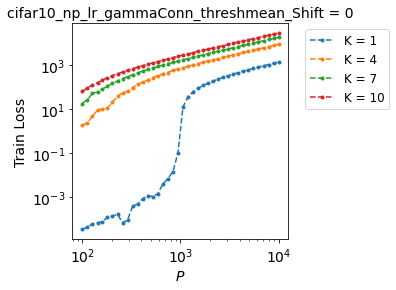

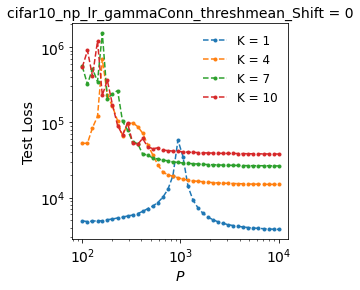

In [31]:
for shiftInd, shift in enumerate(shift_list):
    fig, ax = plt.subplots()
    for KInd, K in enumerate(KVals):
        ax.loglog(num_samples_list, tr_loss.mean(3)[:,KInd,shiftInd], color = colors[KInd%len(colors)], ls = linestyles[0], marker = markerstyles[0], label = 'K = ' + str(K))        
        #ax.errorbar(proj_ratio_list, tr_acc.mean(3)[PInd,KInd,:,shiftInd], tr_acc.std(3)[PInd,KInd,:, shiftInd], label = shift, color = colors[shiftInd], ls = linestyles[KInd])        
#     ylim = ax.get_ylim()[0]
#     for shiftInd, shift in enumerate(shift_list):
#         ax.plot(sparsityFractions[shiftInd], ylim, marker='v', color = colors[shiftInd])
    ax.set_xlabel(r'$P$')
    ax.set_ylabel(r'Train Loss')
    
    #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
    ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    ax.set_title(desc + '_Shift = ' + str(shift))
    set_size(w,h)
    fig = plt.gcf()
    fig.savefig(figPath+'train_loss_plot_Shift'+str(shift)+'.png', dpi = 300, bbox_inches='tight')
    
for shiftInd, shift in enumerate(shift_list):
    fig, ax = plt.subplots()
    for KInd, K in enumerate(KVals):
        ax.loglog(num_samples_list, test_loss.mean(3)[:,KInd,shiftInd], color = colors[KInd%len(colors)], ls = linestyles[0], marker = markerstyles[0], label = 'K = ' + str(K))        
        #ax.errorbar(proj_ratio_list, tr_acc.mean(3)[PInd,KInd,:,shiftInd], tr_acc.std(3)[PInd,KInd,:, shiftInd], label = shift, color = colors[shiftInd], ls = linestyles[KInd])        
#     ylim = ax.get_ylim()[0]
#     for shiftInd, shift in enumerate(shift_list):
#         ax.plot(sparsityFractions[shiftInd], ylim, marker='v', color = colors[shiftInd])
    ax.set_xlabel(r'$P$')
    ax.set_ylabel(r'Test Loss')
    
    #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
    ax.legend(loc = 'upper right', frameon=False)
    ax.set_title(desc + '_Shift = ' + str(shift))
    set_size(w,h)
    fig = plt.gcf()
    fig.savefig(figPath+'test_loss_plot_Shift'+str(shift)+'.png', bbox_inches='tight', dpi = 300)

In [32]:
figPath

'cifar10_np_lr_gammaConn_threshmean_figs/'

In [76]:
#!zip -r mnist_np_lr_DeltaConn_figs.zip mnist_np_lr_DeltaConn_figs